# Phase 1: Distance Threshold Analysis

Analyzes experiment results to determine an optimal cosine distance cutoff for filtering
retrieved memories. The goal is to increase **precision** (reduce false positives) while
maintaining acceptable **recall** (not losing ground truth memories).

All metrics are **macro-averaged**: computed per experiment, then averaged across experiments.
This gives each test case equal weight. Within each experiment, results are deduplicated by
memory ID using the *best* (minimum) distance across all queries.

**Approach:**
1. Collect best-distance data per unique memory per experiment
2. Visualize distance distributions (ground truth vs non-ground-truth)
3. Sweep thresholds and compute precision/recall/F1 (macro-averaged)
4. Identify the optimal cutoff and its tradeoffs

In [9]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

RESULTS_DIR = Path("data/phase1/results")

# Load all experiment result files
result_files = sorted(RESULTS_DIR.glob("results_*.json"))
print(f"Project root: {PROJECT_ROOT}")
print(f"Found {len(result_files)} result files:")
for f in result_files:
    print(f"  {f.name}")

Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Found 11 result files:
  results_tc_review_10_exp_20260202_180709.json
  results_tc_review_11_exp_20260202_180723.json
  results_tc_review_1_exp_20260202_180652.json
  results_tc_review_2_exp_20260202_180739.json
  results_tc_review_3_exp_20260202_180755.json
  results_tc_review_4_exp_20260202_180811.json
  results_tc_review_5_exp_20260202_180830.json
  results_tc_review_6_exp_20260202_180843.json
  results_tc_review_7_exp_20260202_180858.json
  results_tc_review_8_exp_20260202_180915.json
  results_tc_review_9_exp_20260202_180936.json


In [10]:
# Build per-experiment deduped data: best (minimum) distance for each memory across all queries
experiments = []
for f in result_files:
    with open(f) as fh:
        experiments.append(json.load(fh))

# Precompute per-experiment: deduplicated best distances + GT IDs (reused by all cells below)
exp_deduped = []
for exp in experiments:
    tc_id = exp.get("test_case_id", "unknown")
    gt_ids = set(exp.get("ground_truth", {}).get("memory_ids", []))
    best_distances = {}
    for qr in exp.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r["distance"]
            if mid not in best_distances or d < best_distances[mid]:
                best_distances[mid] = d
    exp_deduped.append({
        "tc_id": tc_id,
        "gt_ids": gt_ids,
        "best_distances": best_distances,
    })

# Collect per-observation distances (one entry per experiment×memory pair) — used for histograms
gt_obs_distances = []      # GT observations (each memory appears exactly once since GT sets are disjoint)
non_gt_obs_distances = []  # non-GT observations (same memory appears in ~10 experiments)
gt_memory_details = []     # (memory_id, best_distance, experiment_id)

for ed in exp_deduped:
    for mid, d in ed["best_distances"].items():
        if mid in ed["gt_ids"]:
            gt_obs_distances.append(d)
            gt_memory_details.append((mid, d, ed["tc_id"]))
        else:
            non_gt_obs_distances.append(d)

gt_obs = np.array(gt_obs_distances)
non_gt_obs = np.array(non_gt_obs_distances)

# True unique counts
total_gt_memories = sum(len(ed["gt_ids"]) for ed in exp_deduped)
all_unique_ids = set()
for ed in exp_deduped:
    all_unique_ids.update(ed["best_distances"].keys())
n_unique_memories = len(all_unique_ids)

print(f"Database: {n_unique_memories} unique memories")
print(f"Experiments: {len(exp_deduped)} test cases, GT sets are disjoint (each memory GT in exactly 1)")
print(f"  Total GT assignments: {total_gt_memories} (= {n_unique_memories} unique memories)")
print(f"")
print(f"Observations (experiment × memory pairs, used for histograms):")
print(f"  GT observations:     {len(gt_obs)} (unique — each memory is GT once)")
print(f"  Non-GT observations: {len(non_gt_obs)} (~{n_unique_memories} memories × ~{len(exp_deduped)-1} experiments each)")
print(f"")
print(f"GT distance range:     [{gt_obs.min():.4f}, {gt_obs.max():.4f}]")
print(f"Non-GT distance range: [{non_gt_obs.min():.4f}, {non_gt_obs.max():.4f}]")
print(f"GT mean: {gt_obs.mean():.4f}, median: {np.median(gt_obs):.4f}")
print(f"Non-GT mean: {non_gt_obs.mean():.4f}, median: {np.median(non_gt_obs):.4f}")

print(f"\nPer GT memory details (sorted by distance):")
for mid, d, tc in sorted(gt_memory_details, key=lambda x: x[1]):
    print(f"  {d:.4f}  {mid}  ({tc})")

Database: 41 unique memories
Experiments: 11 test cases, GT sets are disjoint (each memory GT in exactly 1)
  Total GT assignments: 41 (= 41 unique memories)

Observations (experiment × memory pairs, used for histograms):
  GT observations:     41 (unique — each memory is GT once)
  Non-GT observations: 355 (~41 memories × ~10 experiments each)

GT distance range:     [0.2194, 0.9605]
Non-GT distance range: [0.6193, 1.0498]
GT mean: 0.6422, median: 0.6163
Non-GT mean: 0.9052, median: 0.9115

Per GT memory details (sorted by distance):
  0.2194  mem_6f362f1d6808  (tc_review_4)
  0.4162  mem_819630bee3db  (tc_review_11)
  0.4218  mem_788f1dcfbb8c  (tc_review_5)
  0.4580  mem_80962cfd2f56  (tc_review_7)
  0.4604  mem_b09708770b0e  (tc_review_11)
  0.4692  mem_47f0c280ca8f  (tc_review_10)
  0.5191  mem_cc83c544db09  (tc_review_8)
  0.5257  mem_52c300d9d6dc  (tc_review_10)
  0.5348  mem_638ce08683ad  (tc_review_1)
  0.5386  mem_dec07d36f54c  (tc_review_8)
  0.5449  mem_337f95b5d490  (tc_rev

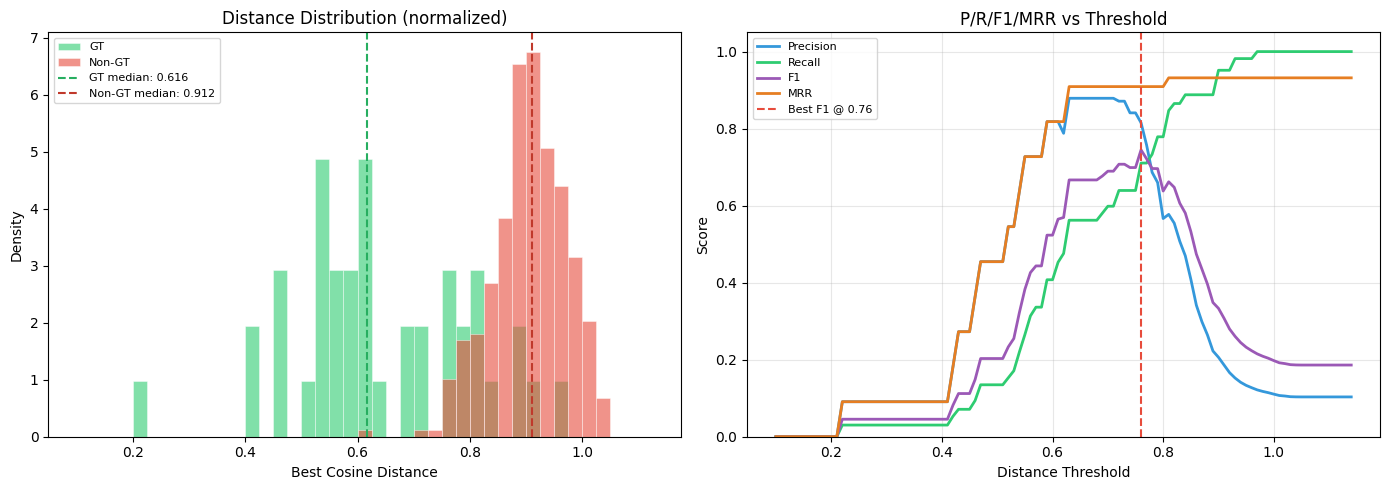


Optimal F1 threshold: 0.76
  F1:        0.745
  Precision: 0.815
  Recall:    0.711
  MRR:       0.909
  (all metrics macro-averaged: per-experiment, then mean)


In [12]:
# Density histogram and threshold sweep (macro-averaged with MRR)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bins = np.arange(0.1, 1.15, 0.025)

# Left: normalized (density) histograms — comparable despite different observation counts
axes[0].hist(gt_obs, bins=bins, alpha=0.6, density=True,
             label="GT", color="#2ecc71", edgecolor="white", linewidth=0.5)
axes[0].hist(non_gt_obs, bins=bins, alpha=0.6, density=True,
             label="Non-GT", color="#e74c3c", edgecolor="white", linewidth=0.5)
axes[0].axvline(np.median(gt_obs), color="#27ae60", linestyle="--", linewidth=1.5,
                label=f"GT median: {np.median(gt_obs):.3f}")
axes[0].axvline(np.median(non_gt_obs), color="#c0392b", linestyle="--", linewidth=1.5,
                label=f"Non-GT median: {np.median(non_gt_obs):.3f}")
axes[0].set_xlabel("Best Cosine Distance")
axes[0].set_ylabel("Density")
axes[0].set_title("Distance Distribution (normalized)")
axes[0].legend(fontsize=8)

# Right: P/R/F1/MRR vs threshold — MACRO-AVERAGED per experiment
exp_thresholds = np.arange(0.10, 1.15, 0.01)
exp_precisions = []
exp_recalls = []
exp_f1_scores = []
exp_mrr_scores = []

for t in exp_thresholds:
    ps, rs, f1s, rrs = [], [], [], []
    for ed in exp_deduped:
        accepted = {mid for mid, d in ed["best_distances"].items() if d <= t}
        gt_accepted = len(accepted & ed["gt_ids"])
        n_accepted = len(accepted)
        gt_count = len(ed["gt_ids"])

        p = gt_accepted / n_accepted if n_accepted > 0 else 0.0
        r = gt_accepted / gt_count if gt_count > 0 else 0.0
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        ps.append(p)
        rs.append(r)
        f1s.append(f1)

        accepted_sorted = sorted(
            [(mid, d) for mid, d in ed["best_distances"].items() if d <= t],
            key=lambda x: x[1]
        )
        rr = 0.0
        for rank, (mid, _) in enumerate(accepted_sorted, 1):
            if mid in ed["gt_ids"]:
                rr = 1.0 / rank
                break
        rrs.append(rr)

    exp_precisions.append(np.mean(ps))
    exp_recalls.append(np.mean(rs))
    exp_f1_scores.append(np.mean(f1s))
    exp_mrr_scores.append(np.mean(rrs))

exp_precisions = np.array(exp_precisions)
exp_recalls = np.array(exp_recalls)
exp_f1_scores = np.array(exp_f1_scores)
exp_mrr_scores = np.array(exp_mrr_scores)

exp_best_f1_idx = np.argmax(exp_f1_scores)
exp_best_threshold = exp_thresholds[exp_best_f1_idx]

axes[1].plot(exp_thresholds, exp_precisions, label="Precision", color="#3498db", linewidth=2)
axes[1].plot(exp_thresholds, exp_recalls, label="Recall", color="#2ecc71", linewidth=2)
axes[1].plot(exp_thresholds, exp_f1_scores, label="F1", color="#9b59b6", linewidth=2)
axes[1].plot(exp_thresholds, exp_mrr_scores, label="MRR", color="#e67e22", linewidth=2)
axes[1].axvline(exp_best_threshold, color="#e74c3c", linestyle="--", linewidth=1.5,
                label=f"Best F1 @ {exp_best_threshold:.2f}")
axes[1].set_xlabel("Distance Threshold")
axes[1].set_ylabel("Score")
axes[1].set_title("P/R/F1/MRR vs Threshold")
axes[1].legend(fontsize=8)
axes[1].set_ylim(0, 1.05)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOptimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  F1:        {exp_f1_scores[exp_best_f1_idx]:.3f}")
print(f"  Precision: {exp_precisions[exp_best_f1_idx]:.3f}")
print(f"  Recall:    {exp_recalls[exp_best_f1_idx]:.3f}")
print(f"  MRR:       {exp_mrr_scores[exp_best_f1_idx]:.3f}")
print(f"  (all metrics macro-averaged: per-experiment, then mean)")

In [4]:
# Threshold table (macro-averaged per experiment, with MRR)
print(f"Threshold table (macro-averaged: per-experiment P/R/F1/MRR, then mean):")
print(f"Database has {n_unique_memories} unique memories, {len(exp_deduped)} test cases")
print()
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Avg Accepted':>13} {'Avg GT Kept':>12} {'Avg GT Lost':>12}")
print("-" * 95)

for t in [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05]:
    ps, rs, f1s, rrs, n_accepted_list, gt_kept_list = [], [], [], [], [], []
    for ed in exp_deduped:
        accepted = {mid for mid, d in ed["best_distances"].items() if d <= t}
        gt_accepted = len(accepted & ed["gt_ids"])
        n_accepted = len(accepted)
        gt_count = len(ed["gt_ids"])

        p = gt_accepted / n_accepted if n_accepted > 0 else 0.0
        r = gt_accepted / gt_count if gt_count > 0 else 0.0
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        ps.append(p)
        rs.append(r)
        f1s.append(f1)
        n_accepted_list.append(n_accepted)
        gt_kept_list.append(gt_accepted)

        accepted_sorted = sorted(
            [(mid, d) for mid, d in ed["best_distances"].items() if d <= t],
            key=lambda x: x[1]
        )
        rr = 0.0
        for rank, (mid, _) in enumerate(accepted_sorted, 1):
            if mid in ed["gt_ids"]:
                rr = 1.0 / rank
                break
        rrs.append(rr)

    avg_p, avg_r = np.mean(ps), np.mean(rs)
    avg_f1, avg_mrr = np.mean(f1s), np.mean(rrs)
    avg_accepted = np.mean(n_accepted_list)
    avg_gt_kept = np.mean(gt_kept_list)
    avg_gt_count = np.mean([len(ed["gt_ids"]) for ed in exp_deduped])
    avg_gt_lost = avg_gt_count - avg_gt_kept

    marker = " <--" if abs(t - exp_best_threshold) < 0.015 else ""
    print(f"{t:>10.2f} {avg_p:>10.3f} {avg_r:>8.3f} {avg_f1:>8.3f} {avg_mrr:>8.3f} {avg_accepted:>13.1f} {avg_gt_kept:>12.1f} {avg_gt_lost:>12.1f}{marker}")

Threshold table (macro-averaged: per-experiment P/R/F1/MRR, then mean):
Database has 41 unique memories, 11 test cases

 Threshold  Precision   Recall       F1      MRR  Avg Accepted  Avg GT Kept  Avg GT Lost
-----------------------------------------------------------------------------------------------
      0.55      0.727    0.265    0.383    0.727           1.1          1.1          2.6
      0.60      0.818    0.408    0.523    0.818           1.6          1.6          2.1
      0.65      0.879    0.562    0.667    0.909           2.3          2.2          1.5
      0.70      0.879    0.598    0.689    0.909           2.5          2.4          1.4
      0.75      0.841    0.639    0.699    0.909           2.8          2.5          1.2 <--
      0.80      0.567    0.779    0.638    0.909           5.5          3.0          0.7
      0.85      0.409    0.888    0.533    0.932           9.5          3.4          0.4
      0.90      0.206    0.952    0.333    0.932          18.0      

In [5]:
# Per-experiment impact of applying the best threshold (with MRR)
print(f"Impact of threshold={exp_best_threshold:.2f} per experiment:\n")
print(f"{'Test Case':<25} {'Recall':>7} {'Prec':>7} {'F1':>7} {'MRR':>7} {'GT':>4} {'Kept':>5} {'Lost':>5} {'Accepted':>9}")
print("-" * 85)

per_exp_mrrs = []
for ed in exp_deduped:
    # Apply threshold and sort by distance
    accepted_sorted = sorted(
        [(mid, d) for mid, d in ed["best_distances"].items() if d <= exp_best_threshold],
        key=lambda x: x[1]
    )
    accepted_ids = {mid for mid, _ in accepted_sorted}
    gt_accepted = accepted_ids & ed["gt_ids"]
    gt_lost = ed["gt_ids"] - accepted_ids

    r = len(gt_accepted) / len(ed["gt_ids"]) if ed["gt_ids"] else 0
    p = len(gt_accepted) / len(accepted_ids) if accepted_ids else 0
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0

    # MRR: reciprocal rank of first GT hit in accepted results (sorted by distance)
    rr = 0.0
    for rank, (mid, _) in enumerate(accepted_sorted, 1):
        if mid in ed["gt_ids"]:
            rr = 1.0 / rank
            break
    per_exp_mrrs.append(rr)

    print(f"{ed['tc_id']:<25} {r:>7.1%} {p:>7.1%} {f1:>7.3f} {rr:>7.3f} {len(ed['gt_ids']):>4} {len(gt_accepted):>5} {len(gt_lost):>5} {len(accepted_ids):>9}")

    if gt_lost:
        for mid in sorted(gt_lost):
            d = ed["best_distances"].get(mid)
            d_str = f"{d:.4f}" if d is not None else "NOT RETRIEVED"
            print(f"  {'':25} Lost: {mid} (best d={d_str})")

print("-" * 85)
avg_accepted = np.mean([len({mid for mid, d in ed["best_distances"].items() if d <= exp_best_threshold}) for ed in exp_deduped])
print(f"{'AVERAGE':<25} {np.mean([len({mid for mid, d in ed['best_distances'].items() if d <= exp_best_threshold} & ed['gt_ids']) / len(ed['gt_ids']) for ed in exp_deduped]):>7.1%} {'':>7} {'':>7} {np.mean(per_exp_mrrs):>7.3f} {'':>4} {'':>5} {'':>5} {avg_accepted:>9.1f}")

Impact of threshold=0.76 per experiment:

Test Case                  Recall    Prec      F1     MRR   GT  Kept  Lost  Accepted
-------------------------------------------------------------------------------------
tc_review_10               100.0%  100.0%   1.000   1.000    5     5     0         5
tc_review_11                75.0%  100.0%   0.857   1.000    4     3     1         3
                            Lost: mem_8df897f58579 (best d=0.8304)
tc_review_1                100.0%  100.0%   1.000   1.000    3     3     0         3
tc_review_2                  0.0%    0.0%   0.000   0.000    2     0     2         1
                            Lost: mem_13c005e3e7f9 (best d=0.8991)
                            Lost: mem_bd7e14fb86d7 (best d=0.8000)
tc_review_3                 50.0%  100.0%   0.667   1.000    2     1     1         1
                            Lost: mem_7847dca3ec16 (best d=0.7894)
tc_review_4                 66.7%  100.0%   0.800   1.000    3     2     1         2
         

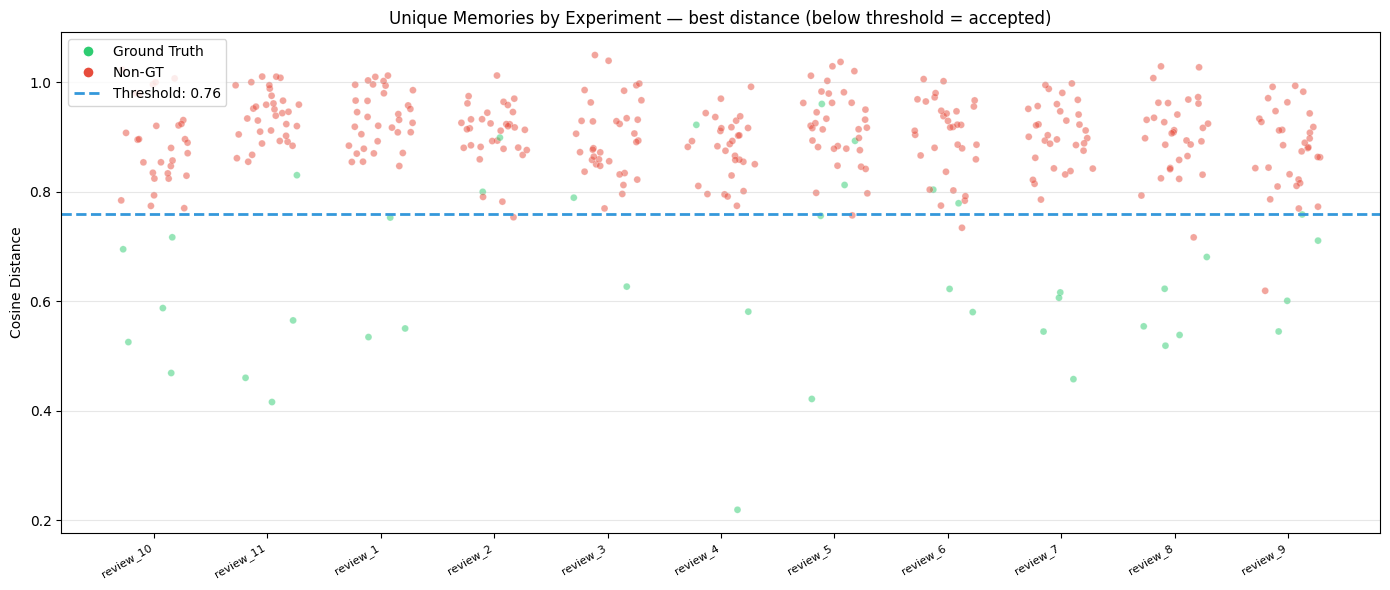


Raw result rows (before dedup): 1940
Unique memories plotted:        396 (36 avg/experiment)
  GT:     41 (3 avg/experiment)
  Non-GT: 355 (32 avg/experiment)


In [6]:
# Scatter plot: deduplicated — one point per unique memory per experiment (best distance)
fig, ax = plt.subplots(figsize=(14, 6))

exp_names = [ed["tc_id"].replace("tc_", "")[:30] for ed in exp_deduped]
x_positions = []
colors = []
distances_plot = []

for exp_idx, ed in enumerate(exp_deduped):
    for mid, d in ed["best_distances"].items():
        x_positions.append(exp_idx + np.random.uniform(-0.3, 0.3))
        distances_plot.append(d)
        colors.append("#2ecc71" if mid in ed["gt_ids"] else "#e74c3c")

ax.scatter(x_positions, distances_plot, c=colors, alpha=0.5, s=25, edgecolors="white", linewidth=0.3)
ax.axhline(exp_best_threshold, color="#3498db", linestyle="--", linewidth=2,
           label=f"Optimal threshold: {exp_best_threshold:.2f}")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=8, label='Ground Truth'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=8, label='Non-GT'),
    Line2D([0], [0], color='#3498db', linestyle='--', linewidth=2, label=f'Threshold: {exp_best_threshold:.2f}'),
]
ax.legend(handles=legend_elements, loc="upper left")

ax.set_xticks(range(len(exp_names)))
ax.set_xticklabels(exp_names, rotation=30, ha="right", fontsize=8)
ax.set_ylabel("Cosine Distance")
ax.set_title("Unique Memories by Experiment — best distance (below threshold = accepted)")
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print counts
total_raw = sum(
    len(r) for exp in experiments for qr in exp.get("queries", []) for r in [qr.get("results", [])]
)
n_gt_plotted = colors.count('#2ecc71')
n_non_gt_plotted = colors.count('#e74c3c')
print(f"\nRaw result rows (before dedup): {total_raw}")
print(f"Unique memories plotted:        {len(distances_plot)} ({len(distances_plot)//len(exp_deduped):.0f} avg/experiment)")
print(f"  GT:     {n_gt_plotted} ({n_gt_plotted//len(exp_deduped):.0f} avg/experiment)")
print(f"  Non-GT: {n_non_gt_plotted} ({n_non_gt_plotted//len(exp_deduped):.0f} avg/experiment)")

In [7]:
# Analyze the current confidence buckets from db.py vs data-driven buckets
# Uses per-observation data (GT observations are unique; non-GT repeated across experiments)
current_buckets = [
    ("high",     0.0,  0.5),
    ("medium",   0.5,  0.8),
    ("low",      0.8,  1.2),
    ("very_low", 1.2,  2.0),
]

print(f"Current confidence buckets (db.py) vs actual data:")
print(f"NOTE: GT observations are unique (n={len(gt_obs)}), non-GT are repeated across experiments (n={len(non_gt_obs)} from {n_unique_memories} memories)")
print()
print(f"{'Bucket':<10} {'Range':<15} {'GT Obs':>10} {'Non-GT Obs':>12} {'GT %':>8} {'Obs Precision':>14}")
print("-" * 75)

for name, lo, hi in current_buckets:
    gt_in = int(np.sum((gt_obs >= lo) & (gt_obs < hi)))
    non_gt_in = int(np.sum((non_gt_obs >= lo) & (non_gt_obs < hi)))
    total_in = gt_in + non_gt_in
    gt_pct = gt_in / len(gt_obs) * 100 if len(gt_obs) > 0 else 0
    prec = gt_in / total_in if total_in > 0 else 0
    print(f"{name:<10} [{lo:.1f}, {hi:.1f}){'':<5} {gt_in:>10} {non_gt_in:>12} {gt_pct:>7.1f}% {prec:>14.1%}")

print(f"\nRecommendation: Update confidence buckets based on data distribution.")
print(f"The optimal F1 threshold ({exp_best_threshold:.2f}) should be the cutoff between 'accepted' and 'rejected'.")

Current confidence buckets (db.py) vs actual data:
NOTE: GT observations are unique (n=41), non-GT are repeated across experiments (n=355 from 41 memories)

Bucket     Range               GT Obs   Non-GT Obs     GT %  Obs Precision
---------------------------------------------------------------------------
high       [0.0, 0.5)               6            0    14.6%         100.0%
medium     [0.5, 0.8)              27           27    65.9%          50.0%
low        [0.8, 1.2)               8          328    19.5%           2.4%
very_low   [1.2, 2.0)               0            0     0.0%           0.0%

Recommendation: Update confidence buckets based on data distribution.
The optimal F1 threshold (0.76) should be the cutoff between 'accepted' and 'rejected'.


In [ ]:
# Final summary and recommendation (macro-averaged, with MRR)
print("=" * 70)
print("THRESHOLD ANALYSIS SUMMARY")
print("=" * 70)

print(f"\nDatabase: {n_unique_memories} unique memories")
print(f"Test cases: {len(exp_deduped)} (GT sets are disjoint, {total_gt_memories} total GT assignments)")
avg_retrieved = np.mean([len(ed["best_distances"]) for ed in exp_deduped])
print(f"Avg memories retrieved per experiment: {avg_retrieved:.1f} / {n_unique_memories}")

print(f"\nOptimal F1 threshold: {exp_best_threshold:.2f}")
print(f"  P={exp_precisions[exp_best_f1_idx]:.1%}, R={exp_recalls[exp_best_f1_idx]:.1%}, "
      f"F1={exp_f1_scores[exp_best_f1_idx]:.3f}, MRR={exp_mrr_scores[exp_best_f1_idx]:.3f}")
print(f"  (all metrics macro-averaged: per-experiment, then mean)")

# Retrieval counts at optimal threshold
avg_accepted = np.mean([len({mid for mid, d in ed["best_distances"].items() if d <= exp_best_threshold}) for ed in exp_deduped])
avg_gt_kept = np.mean([len({mid for mid, d in ed["best_distances"].items() if d <= exp_best_threshold} & ed["gt_ids"]) for ed in exp_deduped])
avg_gt_count = np.mean([len(ed["gt_ids"]) for ed in exp_deduped])
print(f"\n--- Memories retrieved at threshold={exp_best_threshold:.2f} (avg per experiment) ---")
print(f"  {avg_accepted:.1f} / {avg_retrieved:.1f} retrieved memories accepted")
print(f"    GT kept:  {avg_gt_kept:.1f} / {avg_gt_count:.1f}")
print(f"    Non-GT:   {avg_accepted - avg_gt_kept:.1f}")

# Data-driven tradeoff points
print(f"\n--- Key Tradeoff Points (data-driven) ---")
tradeoff_points = [("Best F1", exp_best_threshold)]

# Find lowest threshold where macro-avg recall >= 0.9
recall_90_candidates = exp_thresholds[exp_recalls >= 0.9]
if len(recall_90_candidates) > 0:
    t_recall_90 = recall_90_candidates[0]
    tradeoff_points.append(("Recall >= 90%", t_recall_90))

# Find lowest threshold where macro-avg recall >= 0.95
recall_95_candidates = exp_thresholds[exp_recalls >= 0.95]
if len(recall_95_candidates) > 0:
    t_recall_95 = recall_95_candidates[0]
    tradeoff_points.append(("Recall >= 95%", t_recall_95))

# Find highest threshold where macro-avg precision >= 0.9
prec_90_candidates = exp_thresholds[exp_precisions >= 0.9]
if len(prec_90_candidates) > 0:
    t_prec_90 = prec_90_candidates[-1]
    tradeoff_points.append(("Precision >= 90%", t_prec_90))

# Sort by threshold for readability
tradeoff_points.sort(key=lambda x: x[1])

for label, t in tradeoff_points:
    idx = np.argmin(np.abs(exp_thresholds - t))
    avg_acc_t = np.mean([len({mid for mid, d in ed["best_distances"].items() if d <= t}) for ed in exp_deduped])
    avg_gt_t = np.mean([len({mid for mid, d in ed["best_distances"].items() if d <= t} & ed["gt_ids"]) for ed in exp_deduped])
    print(f"  t={t:.2f} ({label:>17}): P={exp_precisions[idx]:.1%}, R={exp_recalls[idx]:.1%}, "
          f"F1={exp_f1_scores[idx]:.3f}, MRR={exp_mrr_scores[idx]:.3f}, "
          f"avg accepted={avg_acc_t:.1f} ({avg_gt_t:.1f} GT + {avg_acc_t-avg_gt_t:.1f} non-GT)")

print(f"\n--- Recommendation ---")
print(f"The GT and non-GT distributions overlap significantly (GT median={np.median(gt_obs):.3f}, "
      f"non-GT median={np.median(non_gt_obs):.3f}).")
print(f"A single distance threshold cannot cleanly separate them.")
print(f"")
print(f"Practical options:")
print(f"  1. Use threshold={exp_best_threshold:.2f} as DEFAULT_DISTANCE_THRESHOLD for best F1")
print(f"  2. Use a higher threshold to preserve recall, accepting lower precision")
print(f"  3. Combine threshold with additional signals (RRF scoring, re-ranking)")
print(f"     to improve separation beyond what distance alone provides")
print("=" * 70)